In [2]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
print("Set completed")

Set completed


In [9]:

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [10]:
def drop_missing_columns(df, threshold=0.4):
    missing_ratio = df.isna().mean()
    missing_columns = missing_ratio[missing_ratio > threshold].index.tolist()
    print(f'Dropping {len(missing_columns)} columns with more than {threshold*100}% missing values.')
    print(f'Columns to drop: {missing_columns}')
    
    # Drop columns and return the modified DataFrame
    df_dropped = df.drop(columns=missing_columns)
    return df_dropped

In [11]:
df_output = df_train.copy()


In [12]:
df_output = drop_missing_columns(df_output, threshold=0.4)


Dropping 6 columns with more than 40.0% missing values.
Columns to drop: ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [13]:
def drop_zero_columns(df, threshold=0.5):
    # Calculate ratio of zeros in each column
    zero_ratio = (df == 0).astype(int).mean()
    zero_columns = zero_ratio[zero_ratio > threshold].index.tolist()
    
    print(f'Dropping {len(zero_columns)} columns with more than {threshold*100}% zero values.')
    print(f'Columns to drop: {zero_columns}')
    
    # Drop the columns
    df_dropped = df.drop(columns=zero_columns)
    return df_dropped

In [14]:
df_output = drop_zero_columns(df_output, threshold=0.5)


Dropping 13 columns with more than 50.0% zero values.
Columns to drop: ['MasVnrArea', 'BsmtFinSF2', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'WoodDeckSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


In [15]:

def engineer_number_columns(df):
    numeric_cols = df_output.select_dtypes(include=[np.number]).columns.tolist()
    correlations = df_output[numeric_cols].corr()['SalePrice'].sort_values(ascending=False)
    feature_number = correlations[correlations.abs() > 0.4].index.tolist()
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_output[feature_number].corr(), annot=True, fmt=".2f", cmap='coolwarm')
    np.unique(feature_number)
    return feature_number

In [16]:
def engineer_object_columns(df):
    object_cols=df_output.select_dtypes(include=['object']).columns.tolist()
    skewed_features=[]
    for col in object_cols:
        value_counts=df_output[col].value_counts(normalize=True)
        max_proportion=value_counts.max()
        if  max_proportion<0.8:
            skewed_features.append(col)
    return skewed_features

In [17]:
def engineer_object_columns1(df):
    features_ob = ['BsmtExposure','BsmtFinType1','BsmtQual','Exterior1st','Exterior2nd','ExterQual','Foundation','GarageFinish','GarageType','HeatingQC','HouseStyle','KitchenQual','LandSlope','LotConfig','LotShape','MSZoning','Neighborhood','RoofStyle','SaleCondition','YrSold']
    return features_ob

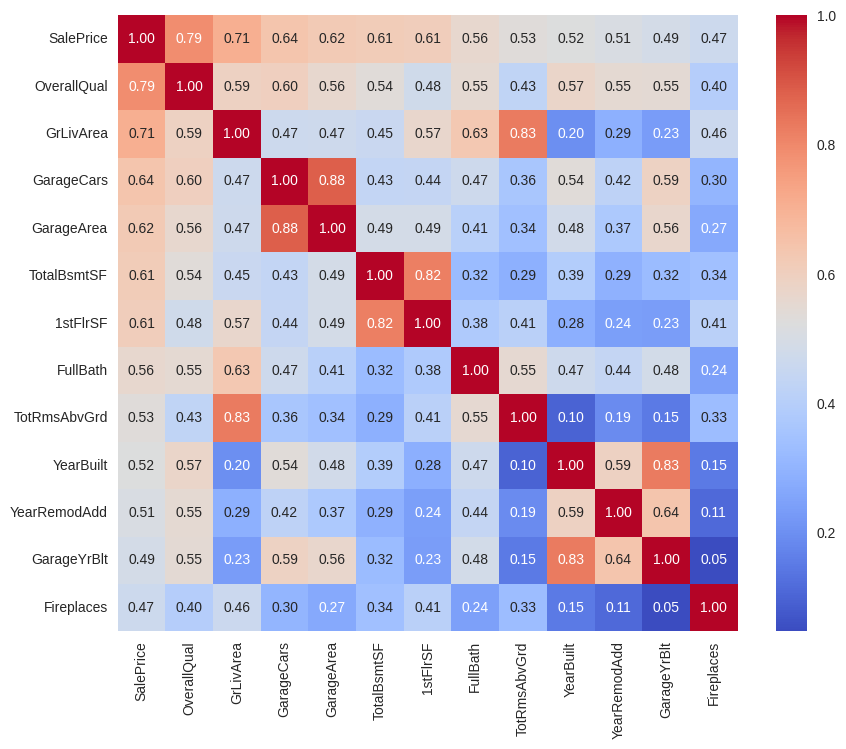

In [18]:
final_feature = engineer_number_columns(df_output) + engineer_object_columns1(df_output)


In [19]:
final_feature

['SalePrice',
 'OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd',
 'GarageYrBlt',
 'Fireplaces',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtQual',
 'Exterior1st',
 'Exterior2nd',
 'ExterQual',
 'Foundation',
 'GarageFinish',
 'GarageType',
 'HeatingQC',
 'HouseStyle',
 'KitchenQual',
 'LandSlope',
 'LotConfig',
 'LotShape',
 'MSZoning',
 'Neighborhood',
 'RoofStyle',
 'SaleCondition',
 'YrSold']

In [20]:
cols_fill_none = ['GarageType', 'GarageFinish', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1']
df_train[cols_fill_none]=df_train[cols_fill_none].fillna('None')

df_train['GarageYrBlt'] = df_train['GarageYrBlt'].fillna(df_train['YearBuilt'])

In [21]:
df_train[final_feature].isnull().sum().sort_values(ascending=False)


SalePrice        0
OverallQual      0
GrLivArea        0
GarageCars       0
GarageArea       0
TotalBsmtSF      0
1stFlrSF         0
FullBath         0
TotRmsAbvGrd     0
YearBuilt        0
YearRemodAdd     0
GarageYrBlt      0
Fireplaces       0
BsmtExposure     0
BsmtFinType1     0
BsmtQual         0
Exterior1st      0
Exterior2nd      0
ExterQual        0
Foundation       0
GarageFinish     0
GarageType       0
HeatingQC        0
HouseStyle       0
KitchenQual      0
LandSlope        0
LotConfig        0
LotShape         0
MSZoning         0
Neighborhood     0
RoofStyle        0
SaleCondition    0
YrSold           0
dtype: int64

In [22]:

cat_cols=df_train[final_feature].select_dtypes(include=['object']).columns.tolist()
num_cols=df_train[final_feature].select_dtypes(include=['number']).columns.tolist()
print("cac cot catogorical:  ",cat_cols)
print("cac cot numeric : ",num_cols)

cac cot catogorical:   ['BsmtExposure', 'BsmtFinType1', 'BsmtQual', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'Foundation', 'GarageFinish', 'GarageType', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandSlope', 'LotConfig', 'LotShape', 'MSZoning', 'Neighborhood', 'RoofStyle', 'SaleCondition']
cac cot numeric :  ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'Fireplaces', 'YrSold']


In [23]:
def check_thong_tin_1_cot(df, col, threshold=0.01):
    print(f"\n===== Column: {col}")
    if col not in df.columns:
        print(f"⚠️ Cột '{col}' không tồn tại trong DataFrame.")
        return df  # tránh lỗi NoneType
    
    vc = df[col].value_counts(normalize=True, dropna=False)

    for cat, pct in vc.items():
        count = df[col].value_counts()[cat]
        print(f"'{cat}' : xuất hiện {count} lần, chiếm {pct:.2%}")

    rare_cats = vc[vc < threshold].index
    if len(rare_cats) > 0:
        print(f"👉 Các giá trị hiếm (<{threshold*100:.0f}%): {list(rare_cats)} -> sẽ gộp thành 'Other'")
        df[col] = df[col].replace(rare_cats, 'Other')
    else:
        print("✅ Không có giá trị hiếm.")
    
    return df


def check_thong_tin_nhieu_cot(df, cols, threshold=0.01):
    for col in cols:
        df = check_thong_tin_1_cot(df, col, threshold)
    return df

In [24]:
def feature_diagnose_simple(df, feature_col, target_col=None):
    """
    Chẩn đoán nhanh 1 feature số:
    - Phát hiện missing, outlier, skew
    - Gợi ý xử lý tiếp theo
    """
    s = df[feature_col]

    # Kiểm tra loại dữ liệu
    if not np.issubdtype(s.dtype, np.number):
        print(f"⚠️ Cột {feature_col} không phải numeric, bỏ qua.")
        return

    print(f"\n===== Feature: {feature_col} =====")
    print(f"Count: {s.count()}, Missing: {s.isna().sum()} ({s.isna().mean():.2%}), Unique: {s.nunique()}")
    print(f"Mean: {s.mean():.2f}, Median: {s.median():.2f}, Std: {s.std():.2f}, Skew: {s.skew():.2f}")

    # IQR outliers
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    outlier_ratio = ((s < lower) | (s > upper)).mean()
    print(f"Outliers (IQR rule): {outlier_ratio:.2%}")

    # Correlation nếu có target
    if target_col is not None:
        corr = df[[feature_col, target_col]].corr().iloc[0,1]
        print(f"Corr({feature_col}, {target_col}) = {corr:.3f}")

    # Gợi ý xử lý
    suggestions = []
    if s.isna().mean() > 0:
        suggestions.append("→ Có missing: nên impute (median hoặc model-based).")
    if outlier_ratio > 0.05:
        suggestions.append("→ Có >5% outliers: nên winsorize hoặc clip.")
    if abs(s.skew()) > 1:
        suggestions.append("→ Skew cao: nên log1p hoặc Yeo-Johnson.")
    elif abs(s.skew()) > 0.5:
        suggestions.append("→ Skew vừa: cân nhắc transform nhẹ.")
    else:
        suggestions.append("→ Phân phối cân bằng: giữ nguyên.")

    print("🩺 Suggestions:")
    for sgg in suggestions:
        print(" ", sgg)

In [25]:
for col in num_cols:
    if col != 'SalePrice':   # bỏ cột target
        feature_diagnose_simple(df_train, col, target_col='SalePrice')


===== Feature: OverallQual =====
Count: 1460, Missing: 0 (0.00%), Unique: 10
Mean: 6.10, Median: 6.00, Std: 1.38, Skew: 0.22
Outliers (IQR rule): 0.14%
Corr(OverallQual, SalePrice) = 0.791
🩺 Suggestions:
  → Phân phối cân bằng: giữ nguyên.

===== Feature: GrLivArea =====
Count: 1460, Missing: 0 (0.00%), Unique: 861
Mean: 1515.46, Median: 1464.00, Std: 525.48, Skew: 1.37
Outliers (IQR rule): 2.12%
Corr(GrLivArea, SalePrice) = 0.709
🩺 Suggestions:
  → Skew cao: nên log1p hoặc Yeo-Johnson.

===== Feature: GarageCars =====
Count: 1460, Missing: 0 (0.00%), Unique: 5
Mean: 1.77, Median: 2.00, Std: 0.75, Skew: -0.34
Outliers (IQR rule): 0.34%
Corr(GarageCars, SalePrice) = 0.640
🩺 Suggestions:
  → Phân phối cân bằng: giữ nguyên.

===== Feature: GarageArea =====
Count: 1460, Missing: 0 (0.00%), Unique: 441
Mean: 472.98, Median: 480.00, Std: 213.80, Skew: 0.18
Outliers (IQR rule): 1.44%
Corr(GarageArea, SalePrice) = 0.623
🩺 Suggestions:
  → Phân phối cân bằng: giữ nguyên.

===== Feature: TotalB

In [26]:
cols_log1p = ['GrLivArea', 'TotalBsmtSF', '1stFlrSF']
for col in cols_log1p:
    df_train[col] = np.log1p(df_train[col])

In [27]:
from sklearn.preprocessing import StandardScaler
cols_keep = ['OverallQual', 'GarageCars', 'GarageArea',
             'FullBath', 'TotRmsAbvGrd',
             'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

scaler = StandardScaler()
df_train[cols_keep] = scaler.fit_transform(df_train[cols_keep])

In [28]:
df_train['HouseAge'] = df_train['YrSold'] - df_train['YearBuilt']
df_train['RemodAge'] = df_train['YrSold'] - df_train['YearRemodAdd']
df_train['TotalSF'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['GrLivArea']

In [29]:
import numpy as np
import pandas as pd

# ====== 1. GỘP CÁC CATEGORY HIẾM ======

def merge_rare_categories(df):
    rare_map = {
        'Exterior1st': ['BrkComm', 'Stone', 'AsphShn', 'ImStucc', 'CBlock'],
        'Exterior2nd': ['ImStucc', 'Brk Cmn', 'Stone', 'AsphShn', 'Other', 'CBlock'],
        'ExterQual': ['Fa'],
        'Foundation': ['Other'],
        'GarageType': ['CarPort', '2Types'],
        'HeatingQC': ['Po'],
        'HouseStyle': ['1.5Unf', '2.5Unf', '2.5Fin'],
        'LandSlope': ['Sev'],
        'LotConfig': ['FR3'],
        'LotShape': ['IR3'],
        'MSZoning': ['C (all)'],
        'Neighborhood': ['Veenker', 'NPkVill', 'Blueste'],
        'RoofStyle': ['Flat', 'Gambrel', 'Mansard', 'Shed'],
        'SaleCondition': ['Alloca', 'AdjLand']
    }
    for col, rare_values in rare_map.items():
        if col in df.columns:
            df[col] = df[col].replace(rare_values, 'Other')
    return df

df_train = merge_rare_categories(df_train)

In [30]:
ordinal_maps = {
    'BsmtExposure': {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4},
    'BsmtFinType1': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
    'BsmtQual':     {'None': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'ExterQual':    {'Other': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'GarageFinish': {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},
    'HeatingQC':    {'Other': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'KitchenQual':  {'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'LandSlope':    {'Other': 0, 'Sev': 1, 'Mod': 2, 'Gtl': 3},
    'LotShape':     {'Other': 0, 'IR3': 1, 'IR2': 2, 'IR1': 3, 'Reg': 4},
}

for col, mapping in ordinal_maps.items():
    if col in df_train.columns:
        df_train[col] = df_train[col].map(mapping).fillna(0).astype(int)

# FE

In [31]:
#c1
# ====== 3. FEATURE ENGINEERING ======

# Tổng điểm chất lượng basement + garage + exterior
df_train['BasementScore'] = df_train['BsmtQual'] + df_train['BsmtExposure'] + df_train['BsmtFinType1']
df_train['GarageScore']   = df_train['GarageFinish'] + df_train['GarageCars']
df_train['ExteriorScore'] = df_train['ExterQual'] + df_train['KitchenQual']

# Tổng diện tích (nếu chưa có)
if {'TotalBsmtSF', '1stFlrSF', 'GrLivArea'}.issubset(df_train.columns):
    df_train['TotalSF'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['GrLivArea']

# Tuổi nhà và tuổi sửa chữa
df_train['HouseAge'] = df_train['YrSold'] - df_train['YearBuilt']
df_train['RemodAge'] = df_train['YrSold'] - df_train['YearRemodAdd']
df_train['GarageAge'] = df_train['YrSold'] - df_train['GarageYrBlt']

In [32]:
from sklearn.preprocessing import OneHotEncoder

nominal_cols = [
    'Exterior1st', 'Exterior2nd', 'Foundation', 'GarageType', 'HouseStyle',
    'LotConfig', 'MSZoning', 'Neighborhood', 'RoofStyle', 'SaleCondition'
]

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded = pd.DataFrame(encoder.fit_transform(df_train[nominal_cols]),
                       columns=encoder.get_feature_names_out(nominal_cols),
                       index=df_train.index)

df_train = pd.concat([df_train.drop(columns=nominal_cols), encoded], axis=1)

In [35]:
y_train=df_train[]
X_tr, X_val, y_tr, y_val = train_test_split(
    df_train, y_train, test_size=0.2, random_state=42
)

NameError: name 'y_train_log' is not defined

In [33]:
models = {
    'RandomForest': RandomForestRegressor(n_estimators=700, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=1200,  
        random_state=42,
        learning_rate=0.015,  
        max_depth=4,          
        min_samples_split=30, 
        min_samples_leaf=15,  
        subsample=0.8,        
        max_features='sqrt'   
    ),
    'Lasso': Lasso(alpha=0.0005, random_state=42, max_iter=2000),  
    'Ridge': Ridge(alpha=10.0, random_state=42)  
}

results = {}
for name, model in models.items():
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    results[name] = rmse
    print(f"{name} RMSE: {rmse:.4f}")
best_model_name = min(results, key=results.get)
print(f"\nbest_model: {best_model_name}")

NameError: name 'X_tr' is not defined

In [36]:
if best_model_name == 'RandomForest':
    best_model = RandomForestRegressor(n_estimators=700, random_state=42)
elif best_model_name == 'GradientBoosting': best_model = GradientBoostingRegressor(
   n_estimators=1200,  
        random_state=42,
        learning_rate=0.015,  
        max_depth=4,          
        min_samples_split=30, 
        min_samples_leaf=15,  
        subsample=0.8,        # 增加子采样
        max_features='sqrt'   
)
elif best_model_name == 'Lasso':
    best_model = Lasso(alpha=0.0005, random_state=42, max_iter=2000)
else:
    best_model = Ridge(alpha=10.0, random_state=42)

best_model.fit(X_train_selected, y_train_log)


NameError: name 'best_model_name' is not defined

In [37]:
#ensemble
models_to_ensemble = {
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=1200,  
        random_state=42,
        learning_rate=0.015,  
        max_depth=4,          
        min_samples_split=30, 
        min_samples_leaf=15,  
        subsample=0.8,        # 增加子采样
        max_features='sqrt'   
    ),
    'RandomForest': RandomForestRegressor(
        n_estimators=300,  # 减少树数量以加快训练
        random_state=42,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5
    ),
    'Lasso': Lasso(alpha=0.0005, random_state=42, max_iter=2000)  # 调整alpha
}


ensemble_predictions_val = {}
ensemble_models = {}

for name, model in models_to_ensemble.items():
    print(f"Mo hinh: {name}")
    model.fit(X_tr, y_tr)
    ensemble_models[name] = model
    y_pred_val = model.predict(X_val)
    ensemble_predictions_val[name] = y_pred_val
    rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    print(f"{name} RMSE : {rmse:.4f}")


Mo hinh: GradientBoosting


NameError: name 'X_tr' is not defined

In [38]:
weights = {}
for name, pred in ensemble_predictions_val.items():
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    weights[name] = 1 / (rmse + 1e-6)  

total_weight = sum(weights.values())
for name in weights:
    weights[name] /= total_weight

print("\n模型权重:")
for name, weight in weights.items():
    print(f"{name}: {weight:.4f}")

ensemble_val_pred = np.zeros_like(y_val)
for name, pred in ensemble_predictions_val.items():
    ensemble_val_pred += weights[name] * pred

ensemble_rmse = np.sqrt(mean_squared_error(y_val, ensemble_val_pred))
print(f"集成模型验证集RMSE: {ensemble_rmse:.4f}")

if ensemble_rmse < results[best_model_name]:
    print("集成模型表现更好，使用集成模型")
    
    for name, model in models_to_ensemble.items():
        print(f"在整个训练集上重新训练: {name}")
        model.fit(X_train_selected, y_train_log)
        ensemble_models[name] = model
    
    test_predictions_log = np.zeros(X_test_selected.shape[0])
    for name, model in ensemble_models.items():
        pred = model.predict(X_test_selected)
        test_predictions_log += weights[name] * pred
    
else:
    print("最佳单个模型表现更好，使用最佳单个模型")


模型权重:


NameError: name 'y_val' is not defined

In [ ]:
def smart_post_process(predictions, y_train):
    """
    智能后处理：基于训练集分布调整预测值
    """
    predictions_clean = predictions.copy()
    
    train_q1 = np.percentile(y_train, 25)
    train_q3 = np.percentile(y_train, 75)
    train_iqr = train_q3 - train_q1
    lower_bound = train_q1 - 1.5 * train_iqr
    upper_bound = train_q3 + 1.5 * train_iqr
    
    predictions_clean = np.clip(predictions_clean, lower_bound, upper_bound)
    predictions_clean = np.round(predictions_clean / 100) * 100
    
    print(f"后处理范围: [{lower_bound:.0f}, {upper_bound:.0f}]")
    print(f"后处理前统计: 均值={predictions.mean():.0f}, 标准差={predictions.std():.0f}")
    print(f"后处理后统计: 均值={predictions_clean.mean():.0f}, 标准差={predictions_clean.std():.0f}")
    
    return predictions_clean

In [ ]:
test_predictions_log = best_model.predict(X_test_selected)
test_predictions = np.expm1(test_predictions_log)

submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': test_predictions
})
submission.to_csv('submission.csv', index=False)